# Scikit-HEP ecosystem updates

**Note:** although I'm presenting in Jupyter, this is a talk, rather than a tutorial. You don't have to follow along.

<br><br><br><br><br>

## State of the ecosystem

<table width="100%"><tr style="background: white">
    <td align="left" width="50%"><img src="img/shells-border.png" width="95%"></td>
    <td align="right" width="50%"><img src="img/shells-hep.png" width="95%"></td>
</tr></table>

<br><br><br><br><br>

<img src="img/pip-allos-scikithep-log.png" width="100%">

<br><br><br><br><br>

<img src="img/pip-macwin-scikithep-log.png" width="100%">

<br><br><br><br><br>

## There are more tools than I could reasonably tell you about

And that's good! Ideally,

   * each tool does one thing well
   * is maintained by enthusiastic developers with recognition for their work
   * who also know about each other and can ensure that their tools work together

<br><br><br><br><br>

## Illustrative vertical slice: Uproot → Awkward Array → Vector → fastjet → hist

Why these five?

<br><br>

<img src="img/uproot-logo.png" width="200px">

<p style="font-size: 14pt">Reads ROOT data as <span style="background: yellow">arrays</span>.</p>

<br><br>

<img src="img/awkward-logo.png" width="200px">

<p style="font-size: 14pt">Manipulates <span style="background: yellow">arrays</span> of arbitrary data structures.</p>

<br><br>

<img src="img/vector-logo.png" width="200px">

<p style="font-size: 14pt">Manipulates <span style="background: yellow">arrays</span> of 2D, 3D, and Lorentz vectors.</p>

<br><br>

<img src="img/fastjet-logo-300px.png" width="200px">

<p style="font-size: 14pt">Finds jets in <span style="background: yellow">arrays</span> of Lorentz vectors.</p>

<br><br>

<img src="img/hist-logo.png" width="200px">

<p style="font-size: 14pt">Fills histograms with <span style="background: yellow">arrays</span>.</p>

<br><br><br><br><br>

## Major trend (back) to talking about arrays

<img src="img/chep-papers-paradigm.png" width="85%">

<br><br><br><br><br>

## Speedrun through the vertical slice

Get a TTree with Uproot (from a tutorial 2 years ago).

In [1]:
import uproot

In [2]:
tree = uproot.open("https://github.com/jpivarski-talks/2020-04-08-eic-jlab/raw/master/open_charm_18x275_10k.root:events/tree")
tree

<TTree 'tree' (52 branches) at 0x7f171e713c40>

Read some TBranches from it.

In [3]:
components = tree.arrays(["px", "py", "pz", "tot_e"])
components

<Array [{px: [-0.516, -0.246, ... 3.03]}] type='10000 * {"px": var * float64, "p...'>

Reformat them into an array of lists of four-vectors.

In [4]:
import awkward as ak
import vector
vector.register_awkward()

In [5]:
events = ak.zip(
    {"px": components.px, "py": components.py, "pz": components.pz, "E": components.tot_e},
    with_name="Momentum4D",
)
events

<MomentumArray4D [[{px: -0.516, ... E: 3.03}]] type='10000 * var * Momentum4D["p...'>

See that each list has a different length.

In [6]:
ak.num(events)

<Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * int64'>

Run FastJet's anti-$k_T$ clustering algorithm on all events.

In [7]:
import fastjet

In [8]:
cluster_sequence = fastjet.ClusterSequence(
    events,
    fastjet.JetDefinition(fastjet.antikt_algorithm, 0.5),
)
cluster_sequence

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [9]:
clustered_events = cluster_sequence.inclusive_jets()
clustered_events

<MomentumArray4D [[{px: 0.056, ... E: 17.3}]] type='10000 * var * Momentum4D["px...'>

Histogram the number of particles in events and the number of jets in events.

In [10]:
import hist

In [11]:
hist.new.Reg(101, -0.5, 100.5).Double().fill(ak.num(events))

Hist(Regular(101, -0.5, 100.5, label='Axis 0'), storage=Double()) # Sum: 9984.0 (10000.0 with flow)

In [12]:
hist.new.Reg(101, -0.5, 100.5).Double().fill(ak.num(clustered_events))

Hist(Regular(101, -0.5, 100.5, label='Axis 0'), storage=Double()) # Sum: 10000.0

See what happens when you change $\Delta R$!

<br><br><br><br><br>

## The Scikit-HEP way of doing things

Analogous to the concept of code being "Pythonic" or "not Pythonic."

If all libraries have a similar style, it will be easier to make them work together.

<br><br><br><br><br>

### Communication via arrays

Scientific Python beyond HEP communicates via arrays; mostly, but not exclusively NumPy.

[NumPy](https://numpy.org/), [Pandas](https://pandas.pydata.org/), [CuPy](https://cupy.dev/), [Sparse](https://sparse.pydata.org/), [xarray](https://docs.xarray.dev/), [Pint](https://pint.readthedocs.io/), [uncertainties](https://pythonhosted.org/uncertainties/numpy_guide.html), [Dask](https://dask.org/), [JAX](https://jax.readthedocs.io/), [TensorFlow](https://www.tensorflow.org/), [PyTorch](https://pytorch.org/), ... can often be interchanged (duck type).

In [15]:
import graphviz

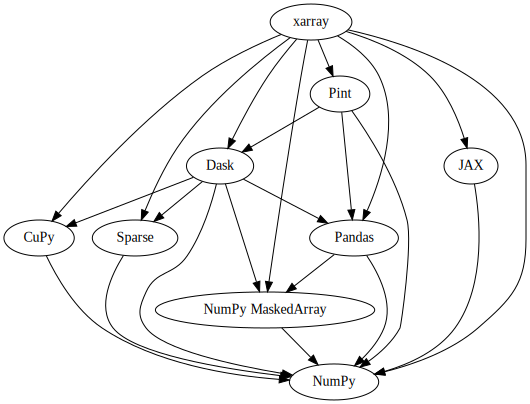

In [20]:
# Credit: Stephan Hoyer https://gist.github.com/shoyer/7936a93843354299368145e8266c5d83
# libraries that only interact with NumPy are not listed, e.g., TensorFlow, PyTorch, scipy.sparse
g = graphviz.Digraph()
g.edge("Dask", "NumPy")
g.edge("Dask", "CuPy")
g.edge("Dask", "Sparse")
g.edge("Dask", "NumPy MaskedArray")
g.edge("Dask", "Pandas")
g.edge("CuPy", "NumPy")
g.edge("Sparse", "NumPy")
g.edge("NumPy MaskedArray", "NumPy")
g.edge("Pandas", "NumPy")
g.edge("Pandas", "NumPy MaskedArray")
g.edge("JAX", "NumPy")
g.edge("Pint", "Dask")
g.edge("Pint", "Pandas")
g.edge("Pint", "NumPy")
g.edge("xarray", "Dask")
g.edge("xarray", "CuPy")
g.edge("xarray", "Sparse")
g.edge("xarray", "NumPy")
g.edge("xarray", "Pandas")
g.edge("xarray", "NumPy MaskedArray")
g.edge("xarray", "Pint")
g.edge("xarray", "JAX")
g

<br><br><br><br><br>

Awkward Array is our contribution to that list.

In [34]:
import skhep_testdata

In [29]:
array = uproot.open(skhep_testdata.data_path("uproot-HZZ.root"))["events"].arrays()
array

<Array [{NJet: 0, ... EventWeight: 0.00876}] type='2421 * {"NJet": int32, "Jet_P...'>

In [31]:
array[0]

<Record ... EventWeight: 0.00927} type='{"NJet": int32, "Jet_Px": var * float32,...'>

In [78]:
nparray = ak.to_numpy(array[["MET_px", "MET_py"]])
nparray

array([(  5.912771,   2.5636332), ( 24.765203, -16.34911  ),
       (-25.785088,  16.237131 ), ..., ( 18.101646,  50.290718 ),
       ( 79.87519 , -52.35145  ), ( 19.713749,  -3.5954182)],
      dtype=[('MET_px', '<f4'), ('MET_py', '<f4')])

<br><br><br><br><br>

But so are Vector's array backends.

In [48]:
vector.MomentumNumpy2D.mro()

[vector._backends.numpy_.MomentumNumpy2D,
 vector._methods.PlanarMomentum,
 vector._methods.Momentum,
 vector._methods.MomentumProtocolPlanar,
 vector._backends.numpy_.VectorNumpy2D,
 vector._backends.numpy_.VectorNumpy,
 vector._methods.Planar,
 vector._methods.Vector2D,
 vector._methods.Vector,
 vector._methods.VectorProtocolPlanar,
 vector._methods.VectorProtocol,
 vector._backends.numpy_.GetItem,
 numpy.ndarray,
 object]

In [79]:
nparray.dtype.names

('MET_px', 'MET_py')

In [80]:
nparray.dtype.names = ["px", "py"]

In [81]:
npvectors = asnumpy.view(vector.MomentumNumpy2D)
npvectors

MomentumNumpy2D([(  5.912771,   2.5636332), ( 24.765203, -16.34911  ),
                 (-25.785088,  16.237131 ), ..., ( 18.101646,  50.290718 ),
                 ( 79.87519 , -52.35145  ), ( 19.713749,  -3.5954182)],
                dtype=[('x', '<f4'), ('y', '<f4')])

In [82]:
npvectors.pt

array([ 6.4446163, 29.675053 , 30.471546 , ..., 53.449284 , 95.502464 ,
       20.038935 ], dtype=float32)

In [83]:
npvectors.to_rhophi()

MomentumNumpy2D([( 6.4446163,  0.40911174), (29.675053 , -0.58348763),
                 (30.471546 ,  2.5796134 ), ..., (53.449284 ,  1.2252938 ),
                 (95.502464 , -0.58017296), (20.038935 , -0.18039851)],
                dtype=[('rho', '<f4'), ('phi', '<f4')])

In [84]:
abs(npvectors)

array([ 6.4446163, 29.675053 , 30.471546 , ..., 53.449284 , 95.502464 ,
       20.038935 ], dtype=float32)

In [87]:
npvectors + vector.obj(pt=100, phi=np.pi)

MomentumNumpy2D([( -94.08723 ,   2.5636332), ( -75.234795, -16.34911  ),
                 (-125.78509 ,  16.237131 ), ..., ( -81.89835 ,  50.290718 ),
                 ( -20.12481 , -52.35145  ), ( -80.286255,  -3.5954182)],
                dtype=[('x', '<f4'), ('y', '<f4')])

<br><br><br><br><br>

Vector (currently!) has three backends:

   * Python object of one vector (for completeness)
   * NumPy subclass of many vectors
   * Awkward Array of vectors in lists and other structures

To make an Awkward Array of Lorentz vectors, name the record `"Momentum4D"` (using `with_name`), name the fields vector components (using `ak.zip`), and

```python
vector.register_awkward()
```

once globally.

Here's a slick one-liner:

In [71]:
akvectors = ak.zip(dict(zip(["px", "py", "pz", "E"], ak.unzip(array[["Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E"]]))), with_name="Momentum4D")
akvectors

<MomentumArray4D [[{px: -52.9, py: -11.7, ... E: 69.6}]] type='2421 * var * Mome...'>

In [73]:
akvectors.pt

<Array [[54.2, 37.7], [24.4, ... 63.6], [42.9]] type='2421 * var * float32'>

In [76]:
akvectors.to_rhophietat()

<MomentumArray4D [[{rho: 54.2, phi: -2.92, ... E: 69.6}]] type='2421 * var * Mom...'>

In [77]:
abs(akvectors)

<Array [[0.105, 0.105], ... [0.106]] type='2421 * var * float32'>

In [89]:
akvectors + vector.obj(pt=100, phi=np.pi, eta=0.5, E=100)

<MomentumArray4D [[{x: -153, y: -11.7, ... t: 170}]] type='2421 * var * Momentum...'>

<br><br><br><br><br>

Quick example: $\Delta R$ between all pairs of muons.

In [91]:
mu1, mu2 = ak.unzip(ak.combinations(akvectors, 2))
mu1, mu2

(<MomentumArray4D [[{px: -52.9, py: -11.7, ... [], []] type='2421 * var * Momentu...'>,
 <MomentumArray4D [[{px: 37.7, py: 0.693, ... [], []] type='2421 * var * Momentum...'>)

In [92]:
mu1.deltaR(mu2)

<Array [[2.95], [], [2.13], ... [], [], [], []] type='2421 * var * float32'>

<br><br><br><br><br>

### Small code-to-data movement ratio